In [1]:
# conda activate realtime

# import packages and data

import sys
#!pip install moscot
#import moscot
import matplotlib.pyplot as plt
# warnings
import warnings
# from matplotlib.errors import MatplotlibDeprecationWarning

# warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)
# warnings.filterwarnings(
#     action="ignore", module="matplotlib", message="'matplotlib.cbook' has no attribute 'mplDeprecation'"
# )
from moscot.problems.time import TemporalProblem
import moscot.plotting as mtp
import cellrank as cr
import scanpy as sc
from cellrank.kernels import RealTimeKernel

sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

In [2]:
import os
out_dir = "/w5home/bmoore/scRNAseq/LiFangChu/fluidigm_gup_expr_results/realtime_02072024/"
os.mkdir(out_dir)

In [3]:
# get adata
adata = sc.read_h5ad("/w5home/bmoore/scRNAseq/LiFangChu/fluidigm_gup_expr_results/output_20231114_102348/clustered_seurat_obj.h5ad")
adata

AnnData object with n_obs × n_vars = 576 × 19084
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

In [4]:

adata.obs["time"] = adata.obs["orig.ident"]#.astype(float).astype("category")
print(adata.obs["time"].unique())
#categories = [1,2,3,4,5,6]
#adata.obs["time"].cat.categories = ["1","2","3","4","5","6"]
#adata.obs["time_numerical"] = adata.obs["time"].astype(float)

['ResyncTime1' 'ResyncTime2' 'ResyncTime3' 'ResyncTime4' 'ResyncTime5'
 'ResyncTime6']


In [5]:
# replacing values
adata.obs["time"].replace(['ResyncTime1', 'ResyncTime2', 'ResyncTime3', 'ResyncTime4', 'ResyncTime5',
 'ResyncTime6'],[1, 2, 3, 4, 5, 6], inplace=True)
print(adata.obs["time"].unique())

[1 2 3 4 5 6]


In [6]:
adata.obs["time"] = adata.obs["time"].astype(float).astype("category")
print(adata.obs["time"].unique())

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
Categories (6, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


In [63]:
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("string").astype("category")
print(adata.obs["seurat_clusters"].unique())

['1', '2', '4', '3', '5', '0']
Categories (6, string): [0, 1, 2, 3, 4, 5]


In [8]:
# visualize this data using the original force-directed layout
# force directed layout 
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.draw_graph(adata, layout='fa')


/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_91820/3396323191.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


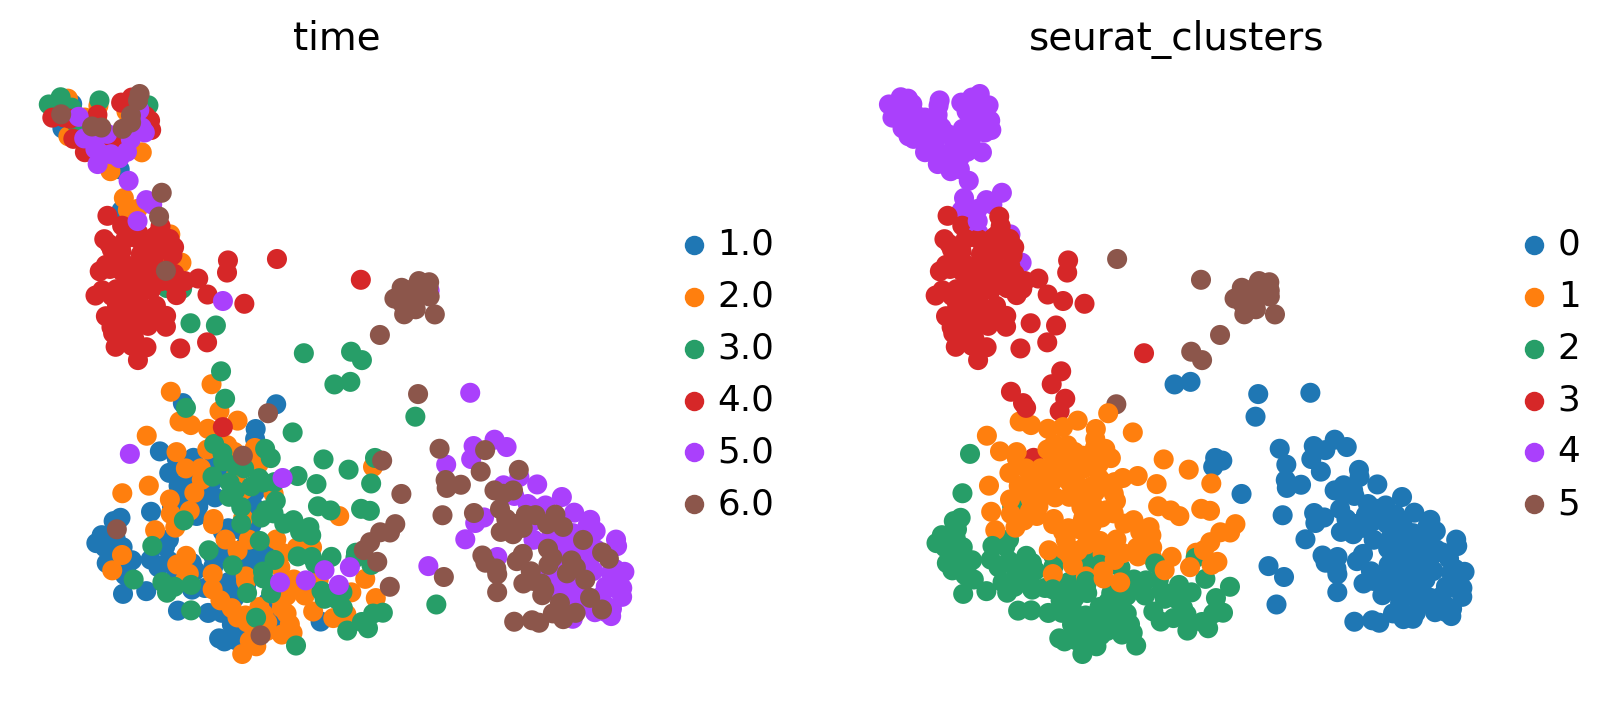

In [9]:
with plt.rc_context():
    sc.pl.embedding(
        adata,
        basis="X_draw_graph_fa",
        color=["time", "seurat_clusters"],
        color_map="gnuplot",
        show=False)
    plt.tight_layout()
    plt.savefig(out_dir + "force_directed_graph.pdf", bbox_inches='tight')

In [10]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_umap, X_draw_graph_fa)


In [11]:
# get proliferation and apopstosis genes
import moscot as mt
from moscot.utils.data import proliferation_markers, apoptosis_markers
p_markers = proliferation_markers("human")
a_markers = apoptosis_markers("human")
print(p_markers,a_markers)
type(p_markers)

['ANLN', 'ANP32E', 'ATAD2', 'AURKA', 'AURKB', 'BIRC5', 'BLM', 'BRIP1', 'BUB1', 'CASP8AP2', 'CBX5', 'CCNB2', 'CCNE2', 'CDC20', 'CDC25C', 'CDC45', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA7', 'CDCA8', 'CDK1', 'CENPA', 'CENPE', 'CENPF', 'CHAF1B', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN', 'CTCF', 'DLGAP5', 'DSCC1', 'DTL', 'E2F8', 'ECT2', 'EXO1', 'FAM64A', 'FEN1', 'G2E3', 'GAS2L3', 'GINS2', 'GMNN', 'GTSE1', 'HELLS', 'HJURP', 'HMGB2', 'HMMR', 'HN1', 'KIF11', 'KIF20B', 'KIF23', 'KIF2C', 'LBR', 'MCM2', 'MCM4', 'MCM5', 'MCM6', 'MKI67', 'MLF1IP', 'MSH2', 'NASP', 'NCAPD2', 'NDC80', 'NEK2', 'NUF2', 'NUSAP1', 'PCNA', 'POLA1', 'POLD3', 'PRIM1', 'PSRC1', 'RAD51', 'RAD51AP1', 'RANGAP1', 'RFC2', 'RPA2', 'RRM1', 'RRM2', 'SLBP', 'SMC4', 'TACC3', 'TIPIN', 'TMPO', 'TOP2A', 'TPX2', 'TTK', 'TUBB4B', 'TYMS', 'UBE2C', 'UBR7', 'UHRF1', 'UNG', 'USP1', 'WDR76'] ['ADD1', 'AIFM3', 'ANKH', 'ANXA1', 'APP', 'ATF3', 'AVPR1A', 'BAX', 'BCAP31', 'BCL10', 'BCL2L1', 'BCL2L10', 'BCL2L11', 'BCL2L2', 'BGN', 'BID', 'BIK', 'BI

list

In [12]:
gene_pool = list(adata.var_names)
print(gene_pool)

['A1BG', 'A1CF', 'A2LD1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS', 'AADAC', 'AADACL2', 'AADACL3', 'AADACL4', 'AADAT', 'AAED1', 'AAGAB', 'AAK1', 'AAMP', 'AANAT', 'AARS', 'AARS2', 'AARSD1', 'AASDH', 'AASDHPPT', 'AASS', 'AATF', 'AATK', 'ABAT', 'ABCA1', 'ABCA10', 'ABCA12', 'ABCA13', 'ABCA2', 'ABCA3', 'ABCA4', 'ABCA5', 'ABCA6', 'ABCA7', 'ABCA8', 'ABCA9', 'ABCB1', 'ABCB10', 'ABCB11', 'ABCB4', 'ABCB5', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCB9', 'ABCC1', 'ABCC10', 'ABCC11', 'ABCC12', 'ABCC2', 'ABCC3', 'ABCC4', 'ABCC5', 'ABCC6', 'ABCC8', 'ABCC9', 'ABCD1', 'ABCD2', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABCG2', 'ABCG4', 'ABCG5', 'ABCG8', 'ABHD1', 'ABHD10', 'ABHD11', 'ABHD12', 'ABHD12B', 'ABHD13', 'ABHD14A', 'ABHD14B', 'ABHD15', 'ABHD16A', 'ABHD16B', 'ABHD2', 'ABHD3', 'ABHD4', 'ABHD5', 'ABHD6', 'ABHD8', 'ABI1', 'ABI2', 'ABI3', 'ABI3BP', 'ABL1', 'ABL2', 'ABLIM1', 'ABLIM2', 'ABLIM3', 'ABO', 'ABP1', 'ABR', 'ABRA', 'ABRACL', 'ABT1', 'ABTB1', 'ABTB2', 'ACAA1', 'ACAA2', 'ACA

In [13]:
'CDC20' in [str(i) for i in adata.var_names]

True

In [14]:
# Reconstruct differentiation trajectory across time points using moscot

# With moscot, we couple cells across time points using optimal transport (OT) by setting up the temporal problem.
tp = TemporalProblem(adata)
# Next, we adjust the marginals for cellular growth- and death rates.
tp = tp.score_genes_for_marginals(
    gene_set_proliferation="human", gene_set_apoptosis="human",use_raw=False
)


/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_91820/1901755499.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


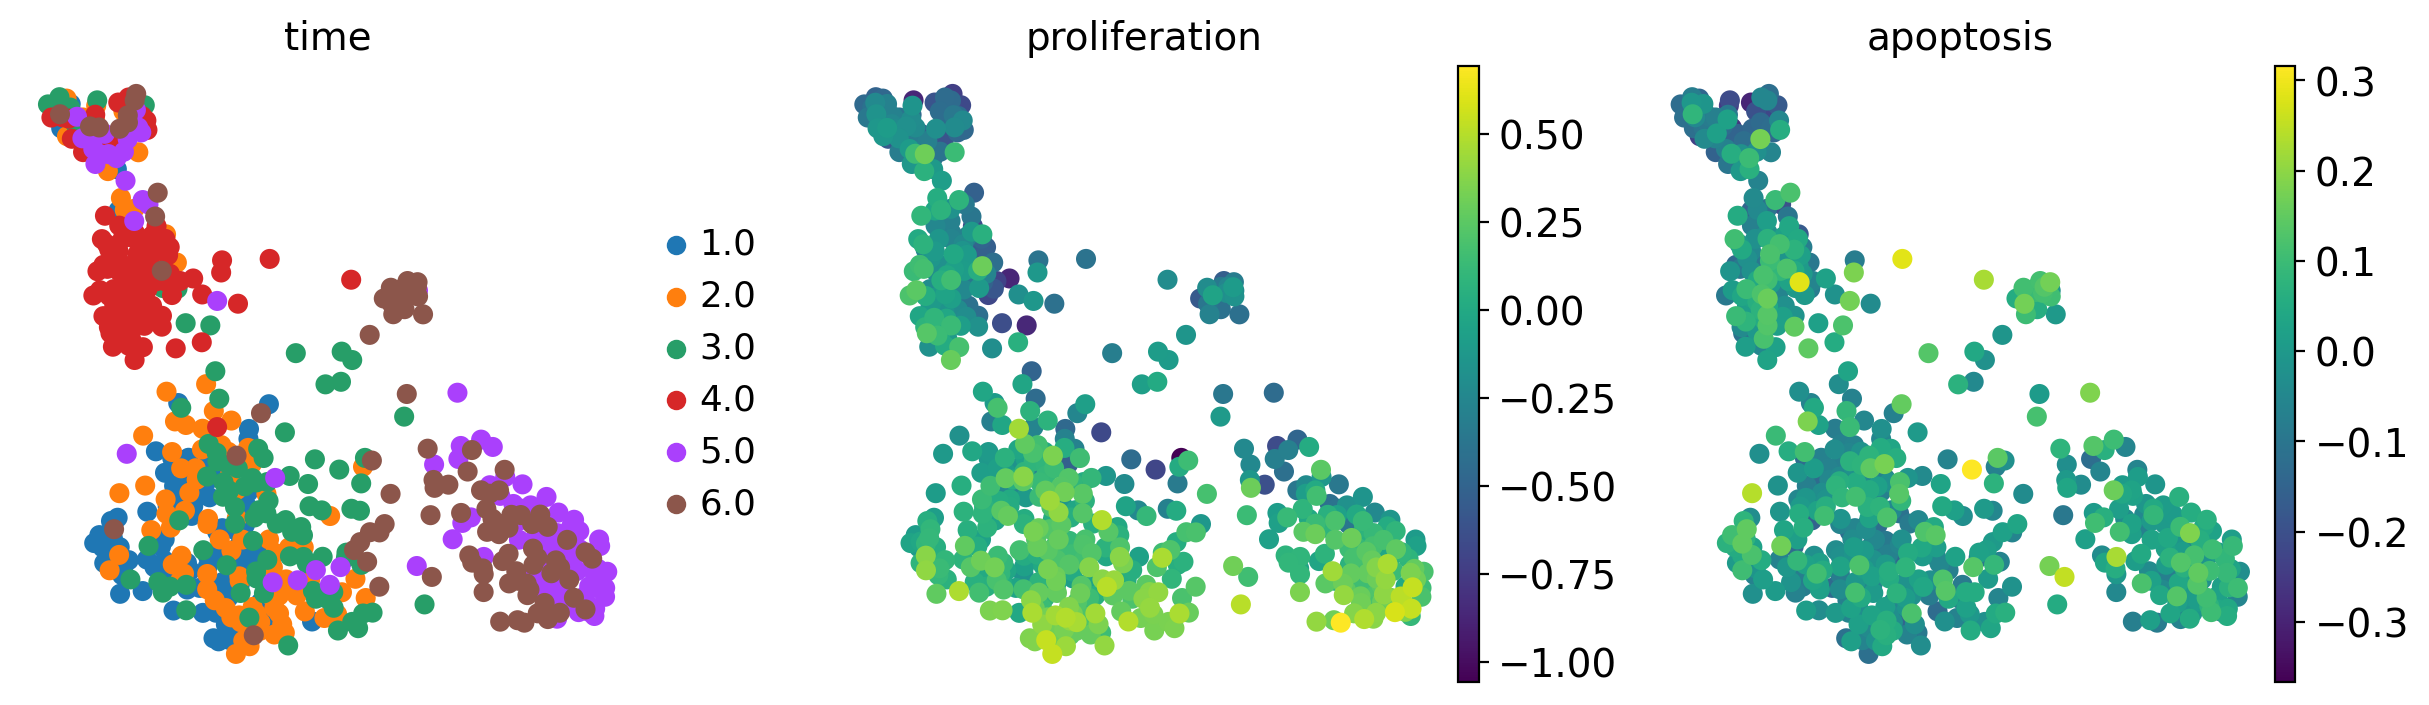

In [15]:
# visualize the proliferation and apoptosis scores
with plt.rc_context():
    sc.pl.embedding(
        adata, basis="X_draw_graph_fa", color=["time", "proliferation", "apoptosis"],
        show=False)
    plt.tight_layout()
    plt.savefig(out_dir + "prolif-apop_graph.pdf", bbox_inches='tight')

In [16]:
# Following the original Waddington OT publication, we use local PCAs, computed separately for each pair of time points, to calulate distances among cells.
tp = tp.prepare(time_key="time")

INFO     Ordering Index(['Sub_805_ResyncTime1_001', 'Sub_805_ResyncTime1_002',                                     
                'Sub_805_ResyncTime1_003', 'Sub_805_ResyncTime1_004',                                              
                'Sub_805_ResyncTime1_005', 'Sub_805_ResyncTime1_006',                                              
                'Sub_805_ResyncTime1_007', 'Sub_805_ResyncTime1_008',                                              
                'Sub_805_ResyncTime1_009', 'Sub_805_ResyncTime1_010',                                              
                ...                                                                                                
                'Sub_810_ResyncTime6_087', 'Sub_810_ResyncTime6_088',                                              
                'Sub_810_ResyncTime6_089', 'Sub_810_ResyncTime6_090',                                              
                'Sub_810_ResyncTime6_091', 'Sub_810_ResyncTime6_092',   

In [17]:
# We solve one OT problem per time point pair, probabilistically matching early to late cells.

tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")
# Above, epsilon and tau_a control the amount of entropic regularization and unbalancedness on the source marginal, respectively. 
# Higher entropic regularization speeds up the optimization and improves statistical properties of the solution [Cuturi, 2013]; 
# unbalancedness makes the solution more robust with respect to uncertain cellular growth rates and biased cell sampling

INFO     Solving `5` problems                                                                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(96, 96)].                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(96, 96)].                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(96, 96)].                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(96, 96)].                                      
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(96, 96)].                                      


In [18]:
# compare prior and posterior growth rates
adata.obs["prior_growth_rates"] = tp.prior_growth_rates
adata.obs["posterior_growth_rates"] = tp.posterior_growth_rates

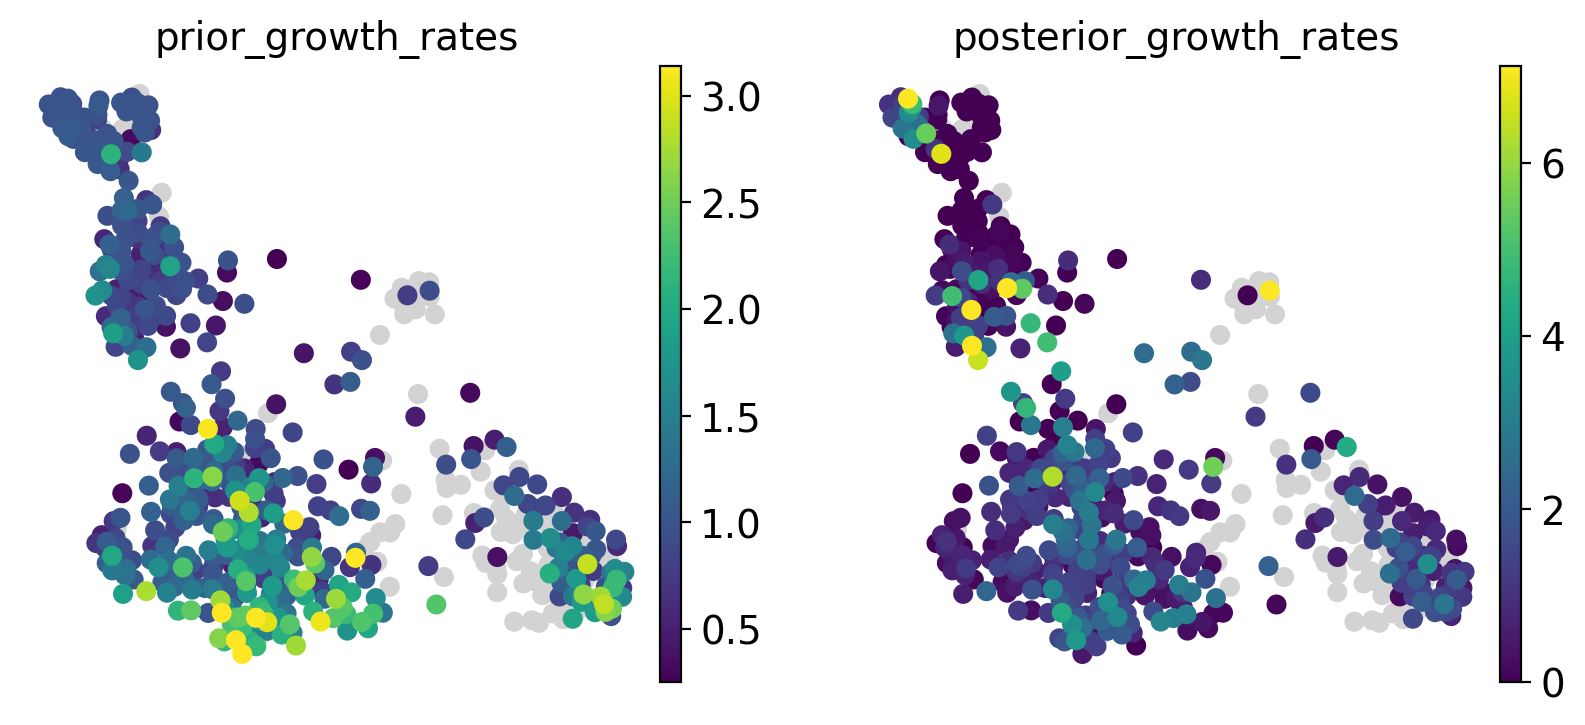

In [19]:
sc.pl.embedding(
    adata,
    basis="X_draw_graph_fa",
    color=["prior_growth_rates", "posterior_growth_rates"],
    vmax="p99",
)

In [20]:
# add cell costs
# High values indicate that a certain cell is unlikely to have a descendant or ancestor
adata.obs["cell_costs_source"] = tp.cell_costs_source
adata.obs["cell_costs_target"] = tp.cell_costs_target

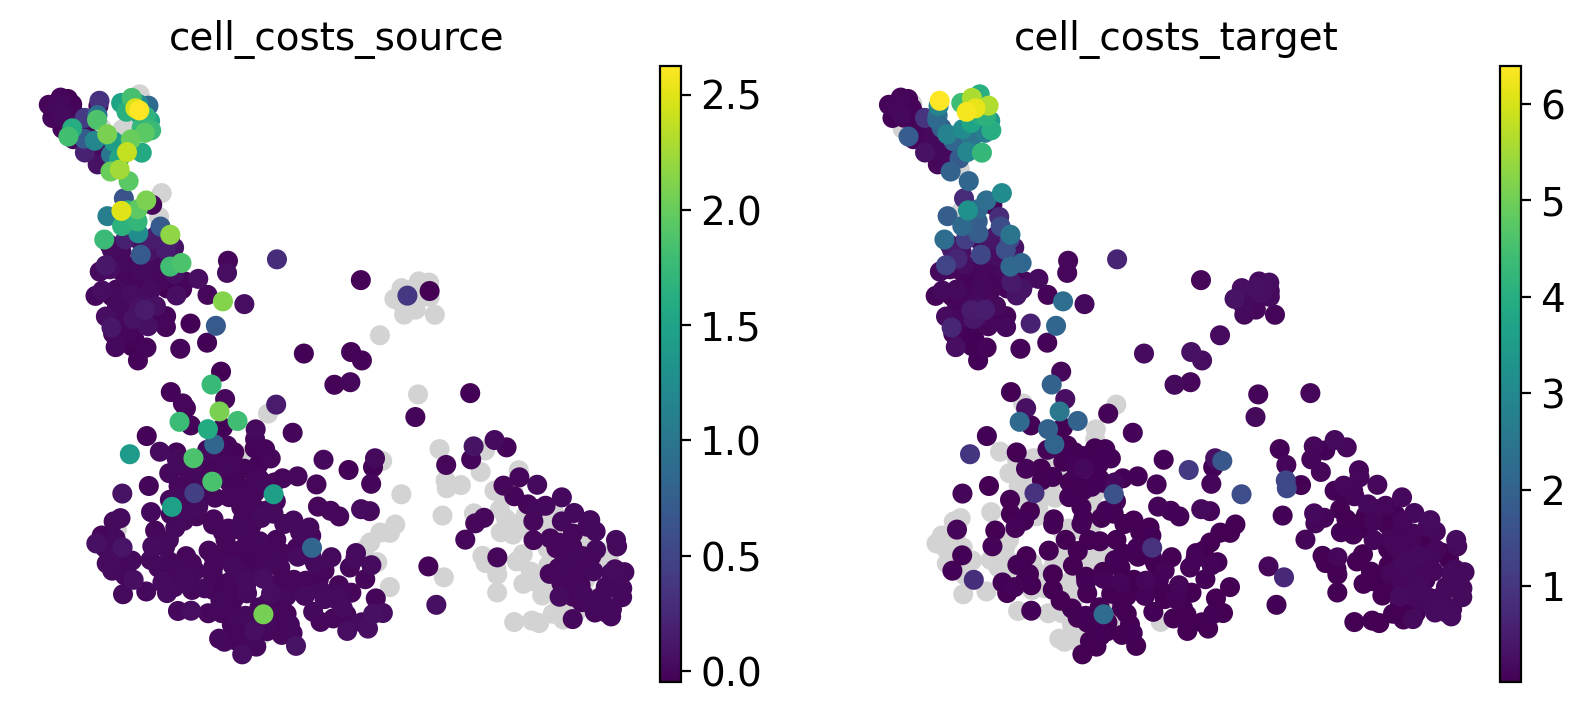

In [21]:
# visulaize cell costs
sc.pl.embedding(
    adata, basis="X_draw_graph_fa", color=["cell_costs_source", "cell_costs_target"]
)

In [30]:
# identfy ancestry of cells
# investigate which ancestry population a certain cell type has. We do this by aggregating the transport matrix by cell type, using cell_transition()
# forward=True means we are plotting descendents, forward=False means we are plotting ancestors
tp.cell_transition(
    source=1, 
    target=2, 
    source_groups="seurat_clusters", 
    target_groups="seurat_clusters", 
    forward=True, 
    key_added="transitions_1_2"
)
tp.cell_transition(
    source=2, 
    target=3, 
    source_groups="seurat_clusters", 
    target_groups="seurat_clusters", 
    forward=True, 
    key_added="transitions_2_3"
)
tp.cell_transition( 
    source=3, 
    target=4, 
    source_groups="seurat_clusters", 
    target_groups="seurat_clusters", 
    forward=True, 
    key_added="transitions_3_4"
)  
tp.cell_transition(
    source=4, 
    target=5, 
    source_groups="seurat_clusters", 
    target_groups="seurat_clusters", 
    forward=True, 
    key_added="transitions_4_5"
)
tp.cell_transition(
    source=5, 
    target=6, 
    source_groups="seurat_clusters", 
    target_groups="seurat_clusters", 
    forward=True, 
    key_added="transitions_5_6"
)

0         1         2             3             4             5
0  8.365941e-01  0.052572  0.020347  1.221102e-05  3.096420e-03  8.737851e-02
1  9.553939e-02  0.228529  0.171163  2.523203e-01  2.524482e-01  0.000000e+00
2  1.436494e-01  0.677420  0.178931  1.059647e-20  1.063431e-33  8.048430e-30
3           NaN       NaN       NaN           NaN           NaN           NaN
4  1.518515e-20  0.000000  0.000000  1.140048e-01  8.859952e-01  0.000000e+00
5  0.000000e+00  0.000000  0.000000  0.000000e+00  0.000000e+00  1.000000e+00

In [31]:
adata.uns['moscot_results']['cell_transition']

{'transitions_1_2': {'source': 1,
  'target': 2,
  'source_groups': 'seurat_clusters',
  'target_groups': 'seurat_clusters',
  'transition_matrix':               0             1             2             3             4
  1  2.921454e-02  7.170874e-01  1.077457e-01  1.167234e-01  2.922892e-02
  2  2.722796e-11  2.554148e-01  7.444863e-01  9.898997e-05  3.027606e-12
  3  4.345094e-32  2.130739e-16  1.595126e-25  2.359716e-06  9.999976e-01
  4  0.000000e+00  0.000000e+00  0.000000e+00  4.555496e-36  1.000000e+00
  5  1.158714e-05  0.000000e+00  9.999884e-01  0.000000e+00  0.000000e+00},
 'transitions_2_3': {'source': 2,
  'target': 3,
  'source_groups': 'seurat_clusters',
  'target_groups': 'seurat_clusters',
  'transition_matrix':               0             1             2             3             4  \
  0  4.999739e-01  9.471812e-24  1.666749e-31  2.500131e-01  0.000000e+00   
  1  5.249256e-02  7.484007e-01  6.389506e-03  1.401101e-01  2.632078e-02   
  2  2.318375e-02  4.514571e-01

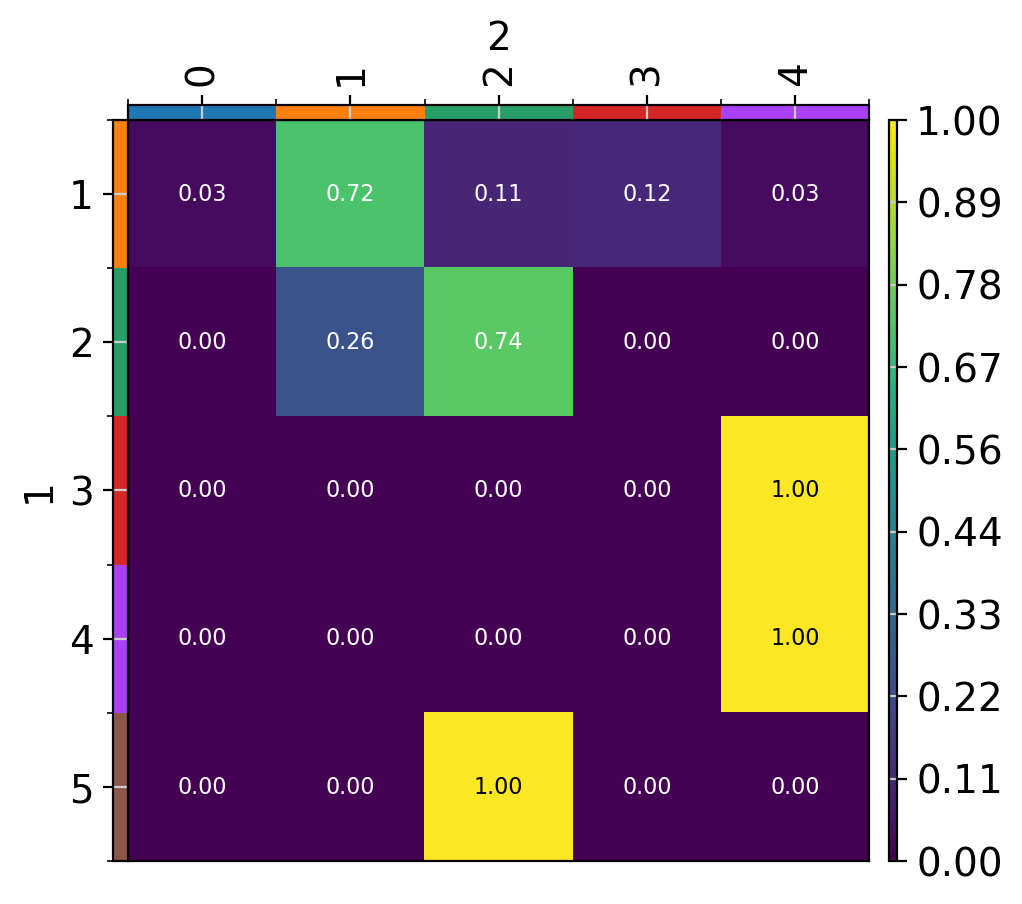

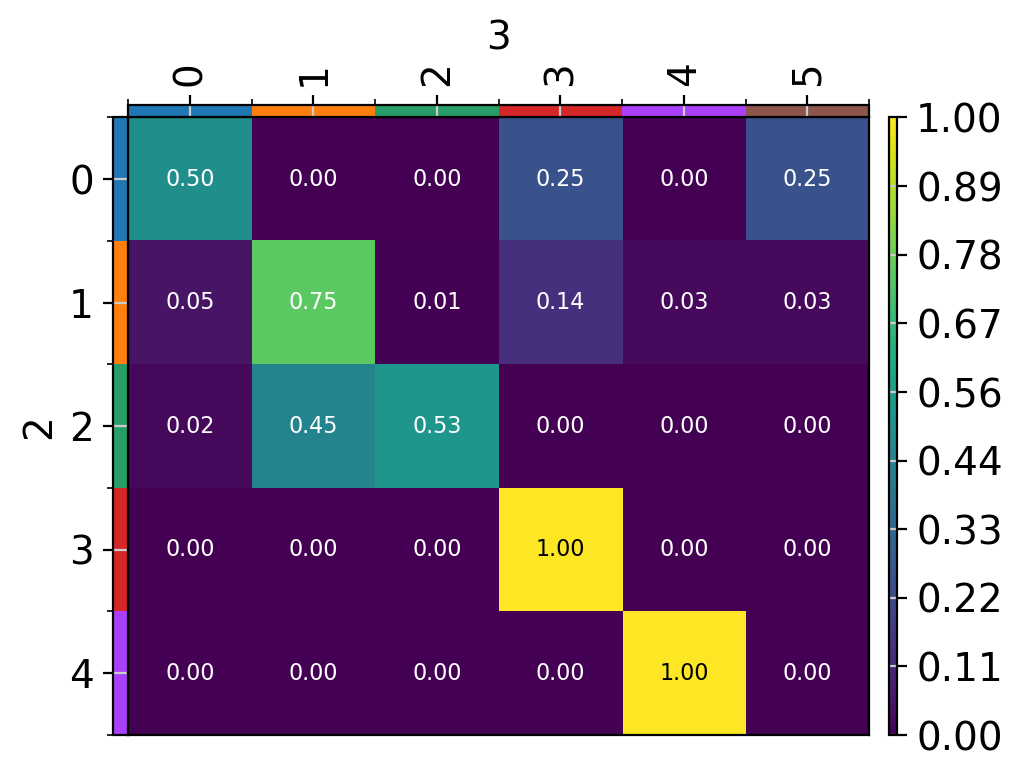

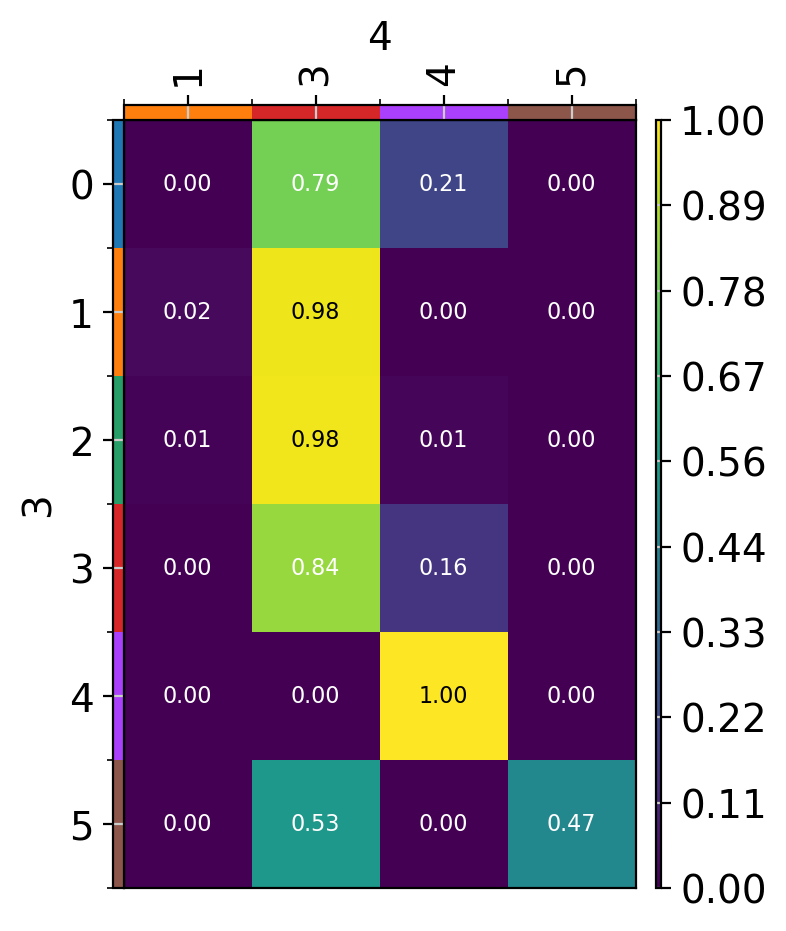

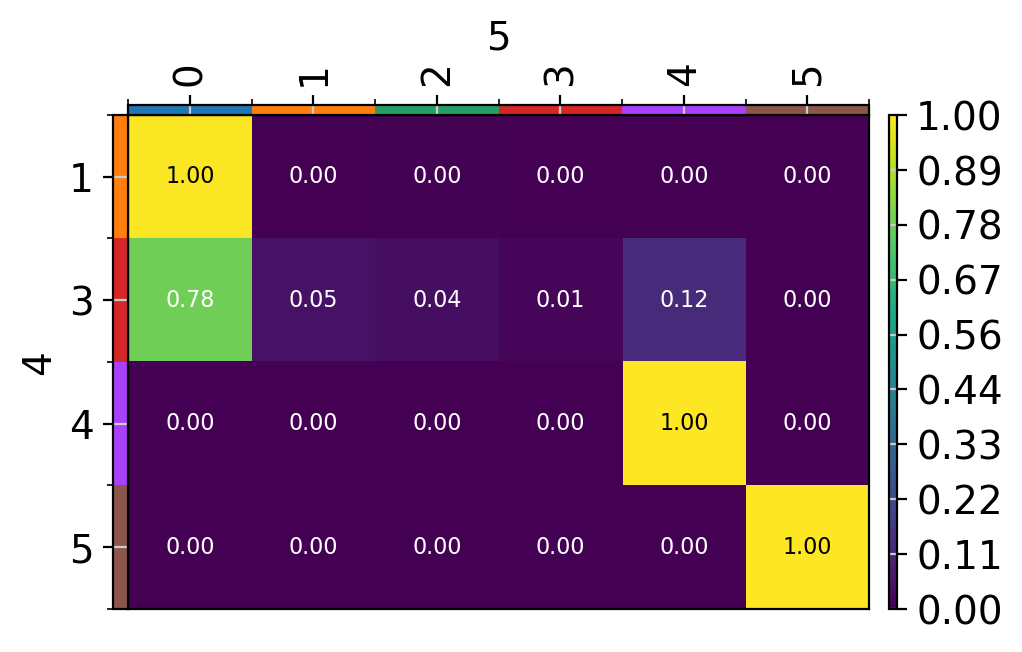

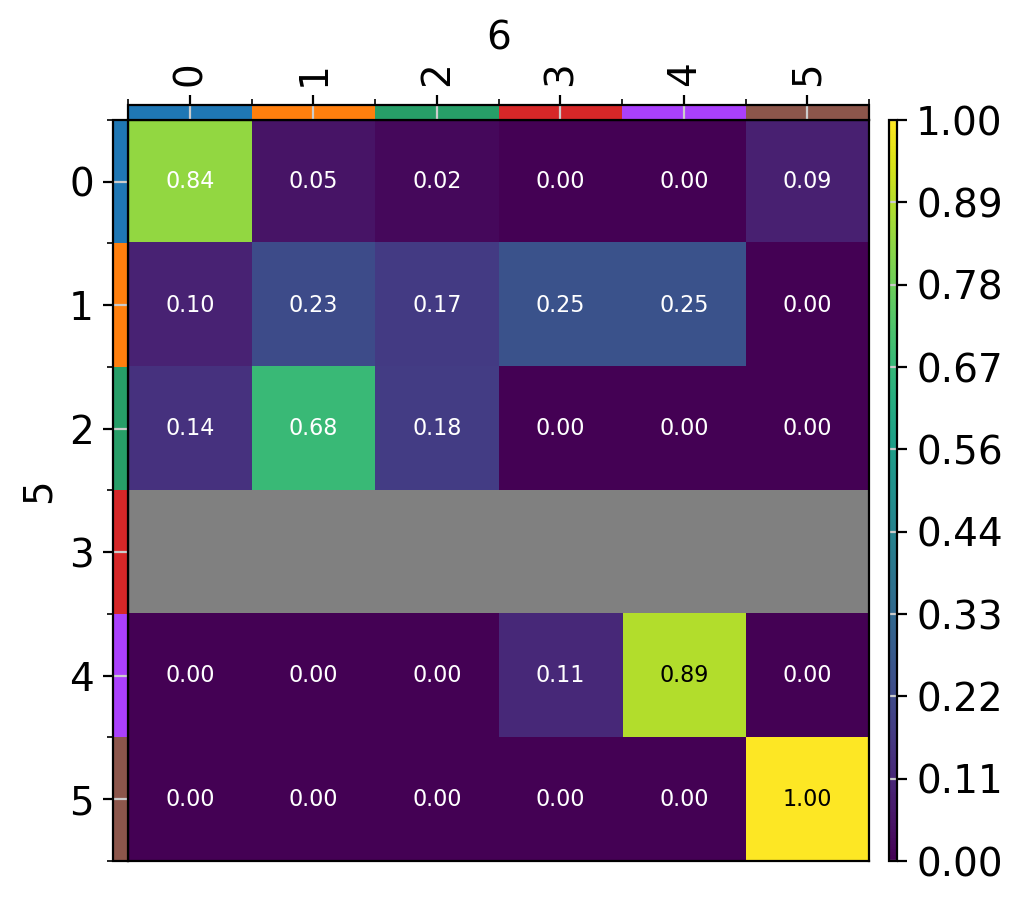

In [49]:
# Create plots
mtp.cell_transition(adata, key="transitions_1_2", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_1-2.png")
mtp.cell_transition(adata, key="transitions_2_3", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_2-3.png")
mtp.cell_transition(adata, key="transitions_3_4", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_3-4.png")
mtp.cell_transition(adata, key="transitions_4_5", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_4-5.png")
mtp.cell_transition(adata, key="transitions_5_6", dpi=100, fontsize=8, save=out_dir + "transitions_heatmap_5-6.png")

/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


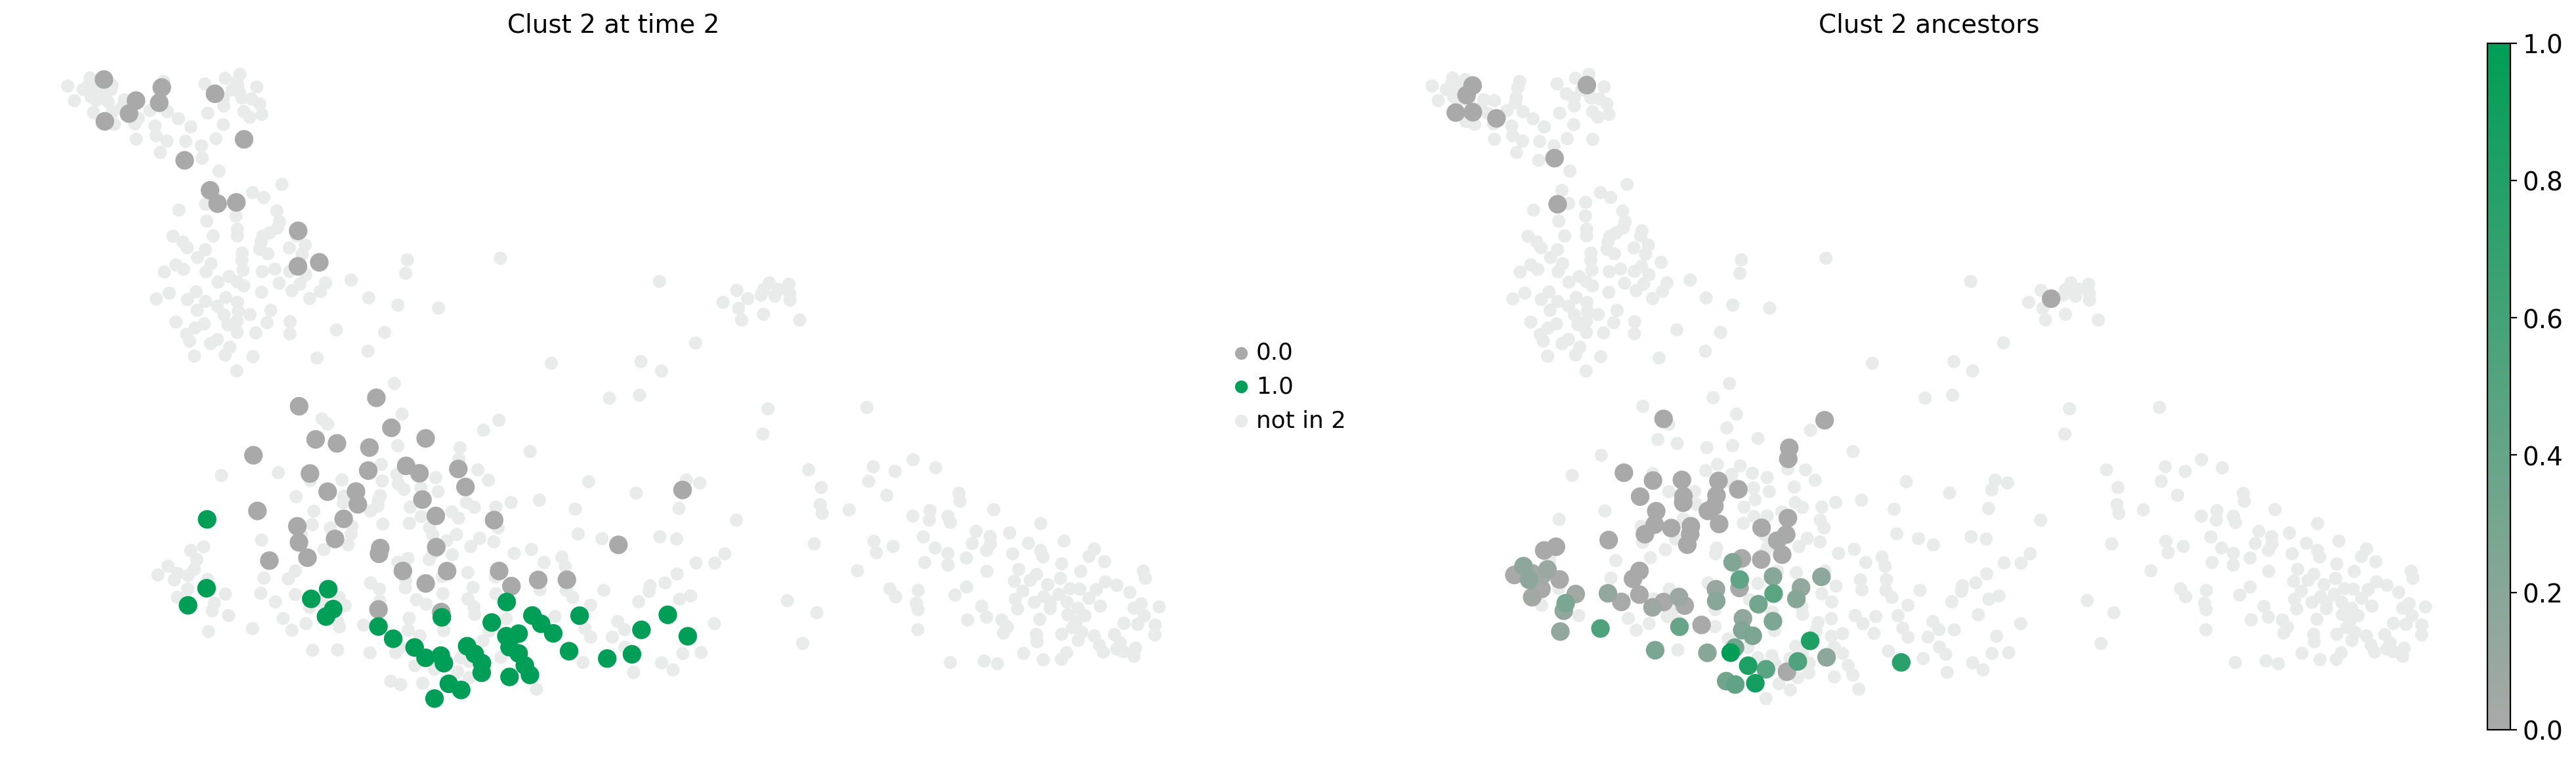

In [50]:
tp.pull(source=1, target=2, data="seurat_clusters", subset=2) # source target are time points
with plt.rc_context():
    fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
    axes[0] = mtp.pull(
        tp,
        time_points=[2],
        basis="X_draw_graph_fa",
        ax=axes[0],
        return_fig=True,
        title=["Clust 2 at time 2"],
    )
    axes[1] = mtp.pull(
        tp,
        time_points=[1],
        basis="X_draw_graph_fa",
        ax=axes[1],
        return_fig=True,
        title=["Clust 2 ancestors"],
    )

    fig.subplots_adjust(wspace=0.2)
    plt.tight_layout()
    plt.savefig(out_dir + "Clust2_ancestors_1-2.pdf", bbox_inches='tight')

/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


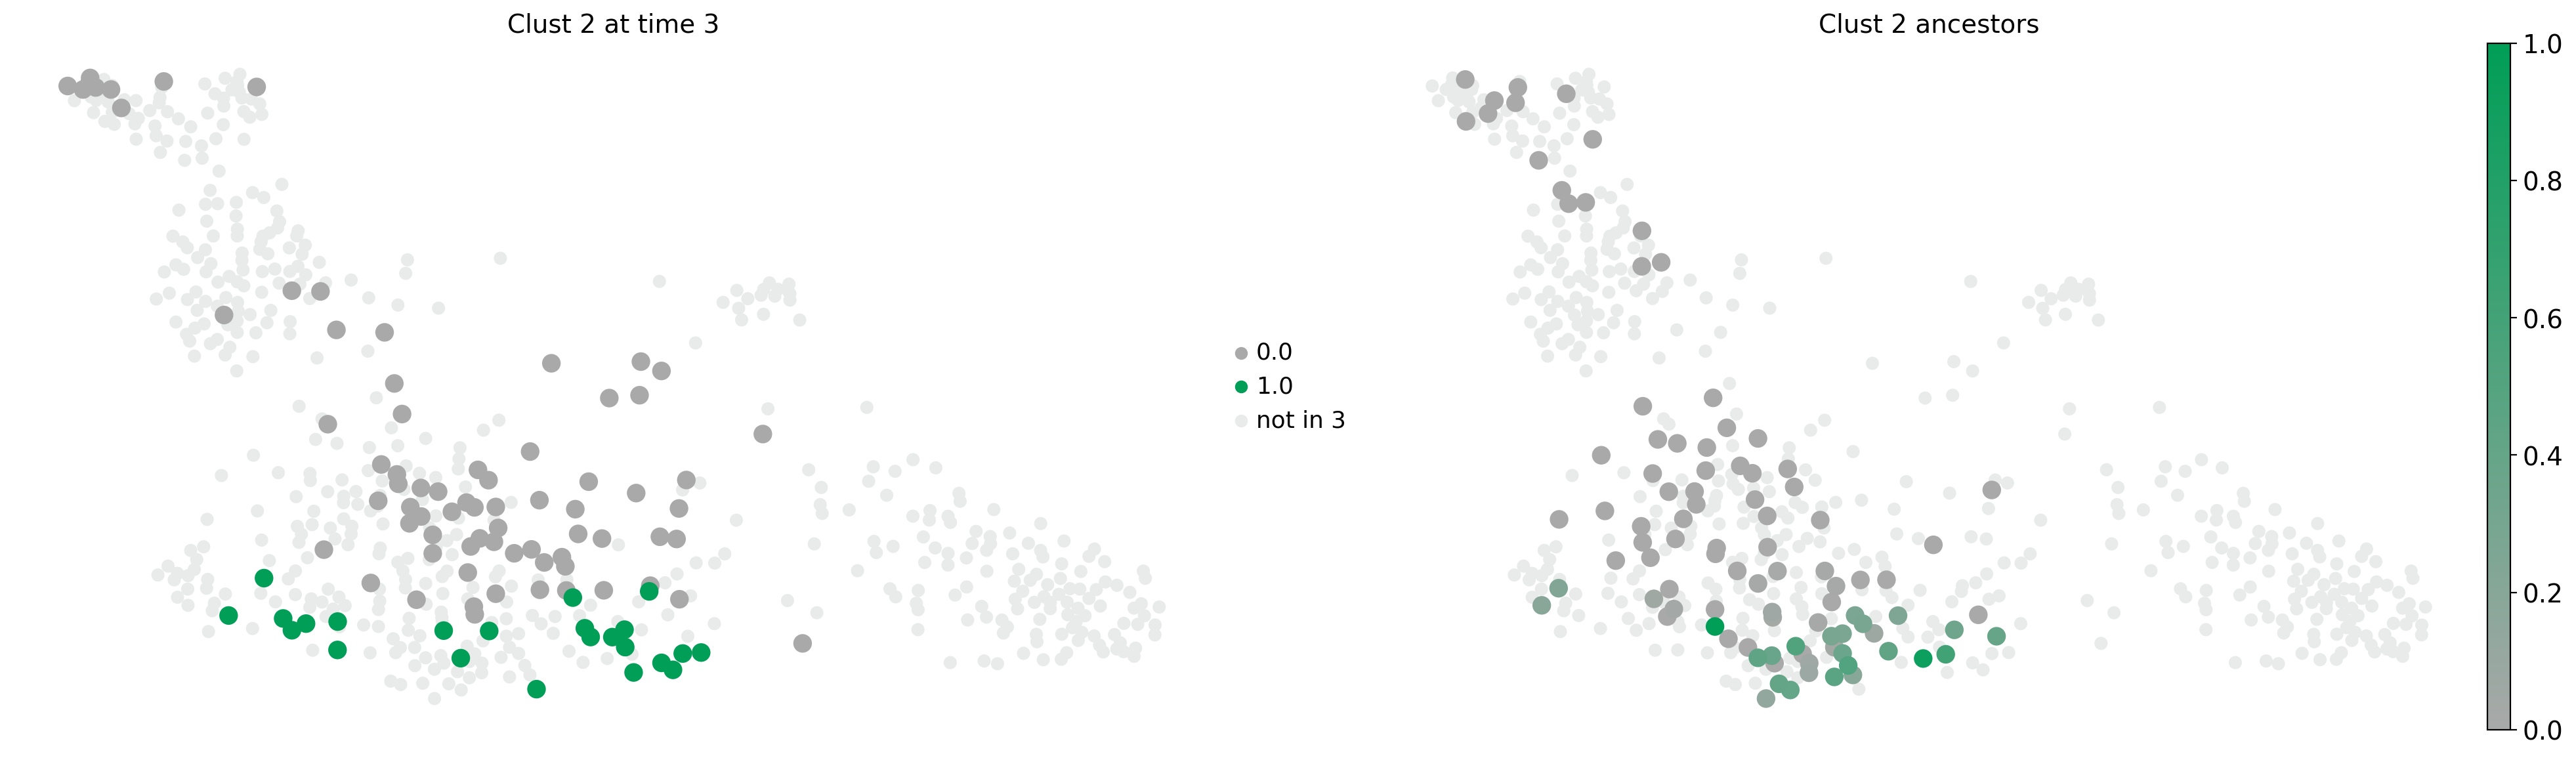

In [51]:
tp.pull(source=2, target=3, data="seurat_clusters", subset=2) # source target are time points
with plt.rc_context():
    fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

    axes[0] = mtp.pull(
        tp,
        time_points=[3],
        basis="X_draw_graph_fa",
        ax=axes[0],
        return_fig=True,
        title=["Clust 2 at time 3"],
    )
    axes[1] = mtp.pull(
        tp,
        time_points=[2],
        basis="X_draw_graph_fa",
        ax=axes[1],
        return_fig=True,
        title=["Clust 2 ancestors"],
    )

    fig.subplots_adjust(wspace=0.2)
    plt.tight_layout()
    plt.savefig(out_dir + "Clust2_ancestors_2-3.pdf", bbox_inches='tight')

/w5home/bmoore/miniconda3/envs/realtime/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


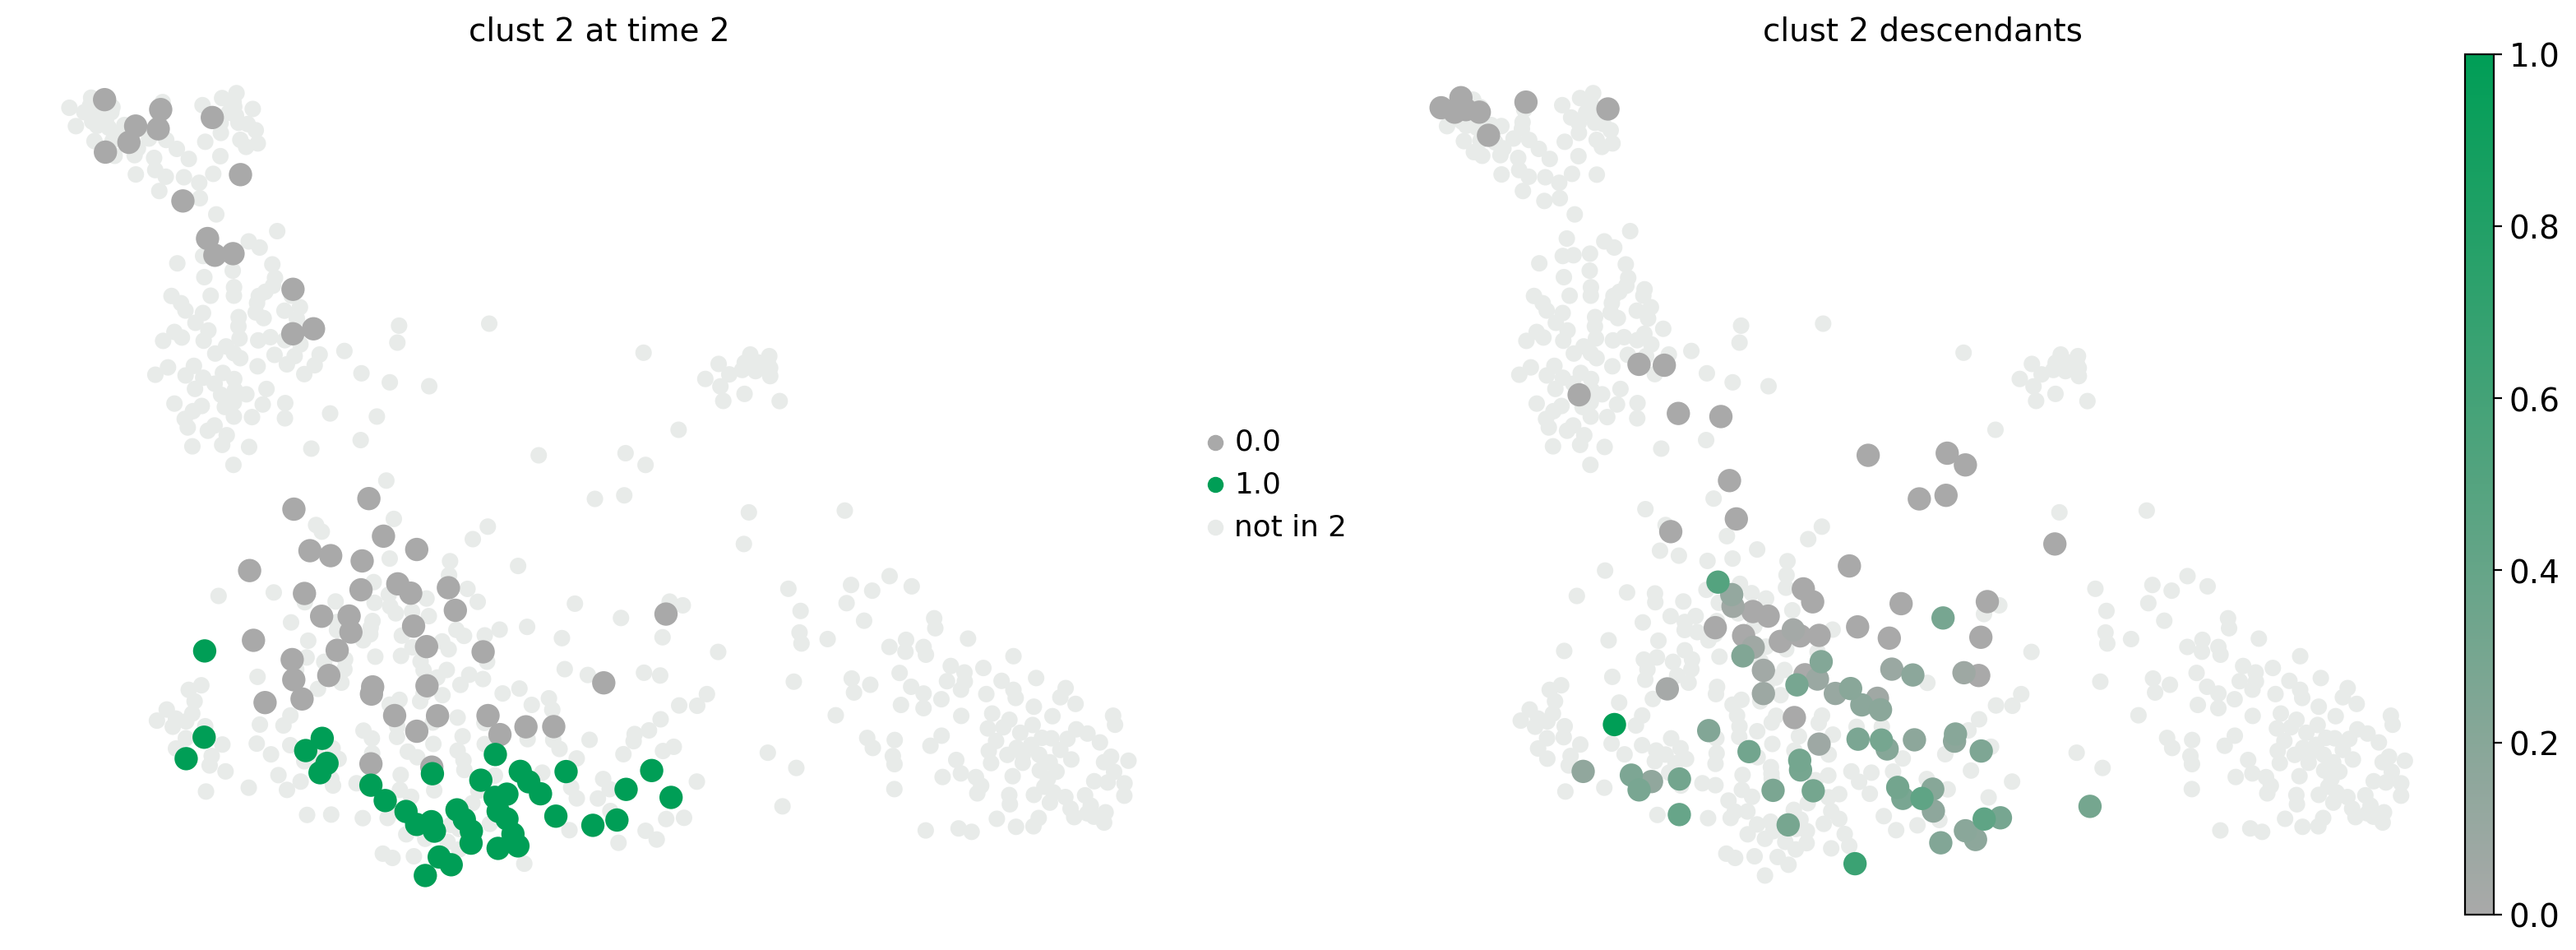

In [52]:
# descendents
tp.push(source=2, target=3, data="seurat_clusters", subset=2)
with plt.rc_context():
    fig, axes = plt.subplots(ncols=2, figsize=(16, 6))

    axes[0] = mtp.push(
        tp,
        time_points=[2],
        basis="X_draw_graph_fa",
        ax=axes[0],
        return_fig=True,
        title=["clust 2 at time 2"],
    )
    axes[1] = mtp.push(
        tp,
        time_points=[3],
        basis="X_draw_graph_fa",
        ax=axes[1],
        return_fig=True,
        title=["clust 2 descendants"],
    )

    fig.subplots_adjust(wspace=0.3)
    plt.tight_layout()
    plt.savefig(out_dir + "Clust2_descendents_2-3.pdf", bbox_inches='tight')

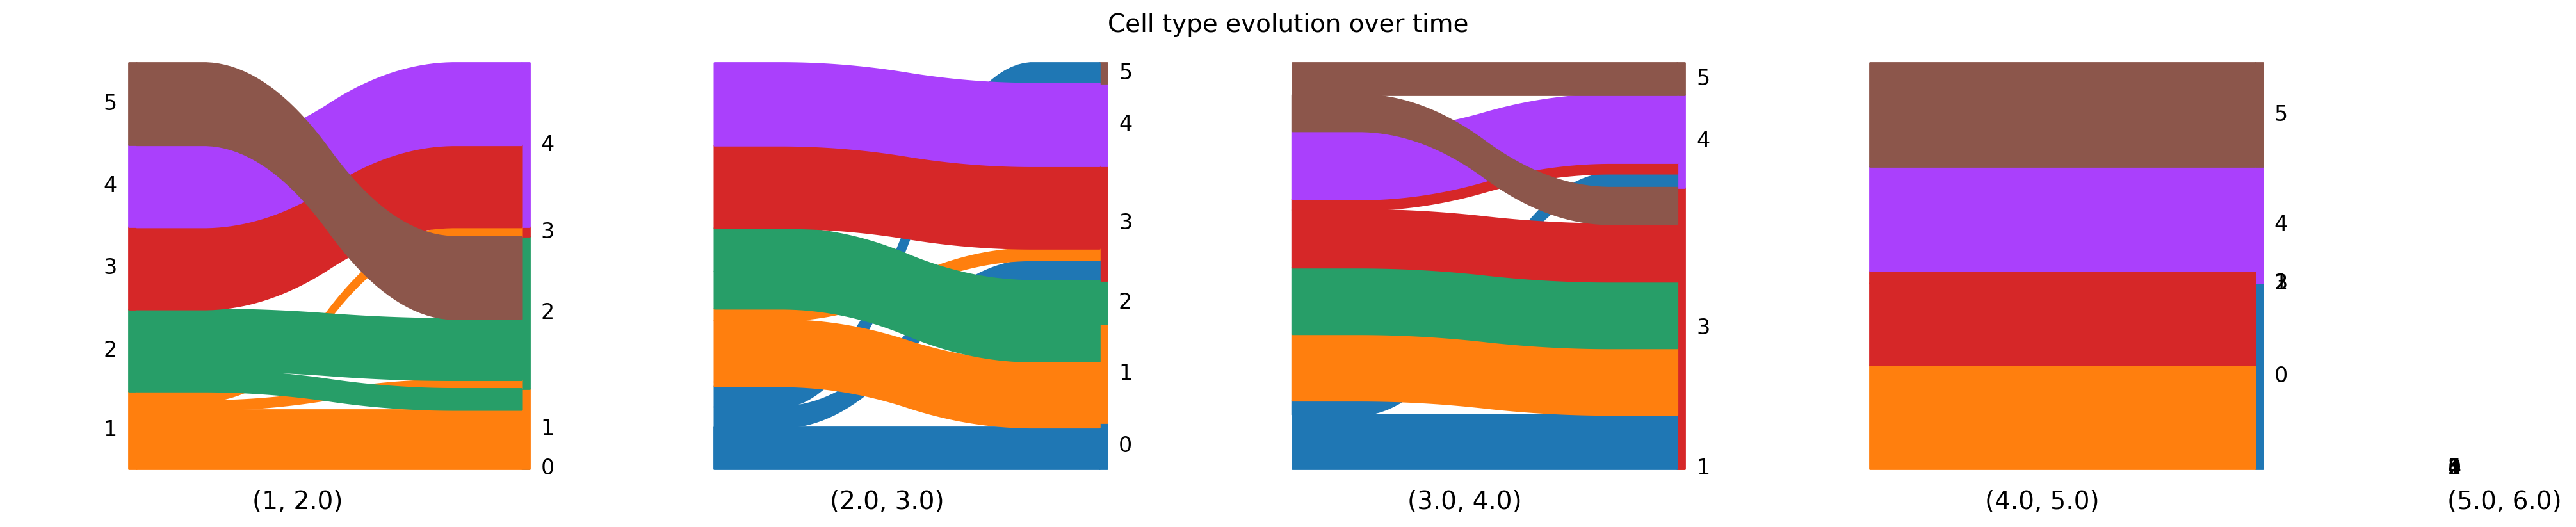

In [55]:
# get dynamics across all time points, we can visualize the cell type evolution
# Sankey diagram allows visualization of flows between cell types
tp.sankey(
    source=1,
    target=6,
    source_groups="seurat_clusters",
    target_groups="seurat_clusters",
    threshold=0.05,
    forward = True,
)
mtp.sankey(tp, dpi=100, figsize=(20, 4), title="Cell type evolution over time", save=out_dir + "cell_type_evolution.png")


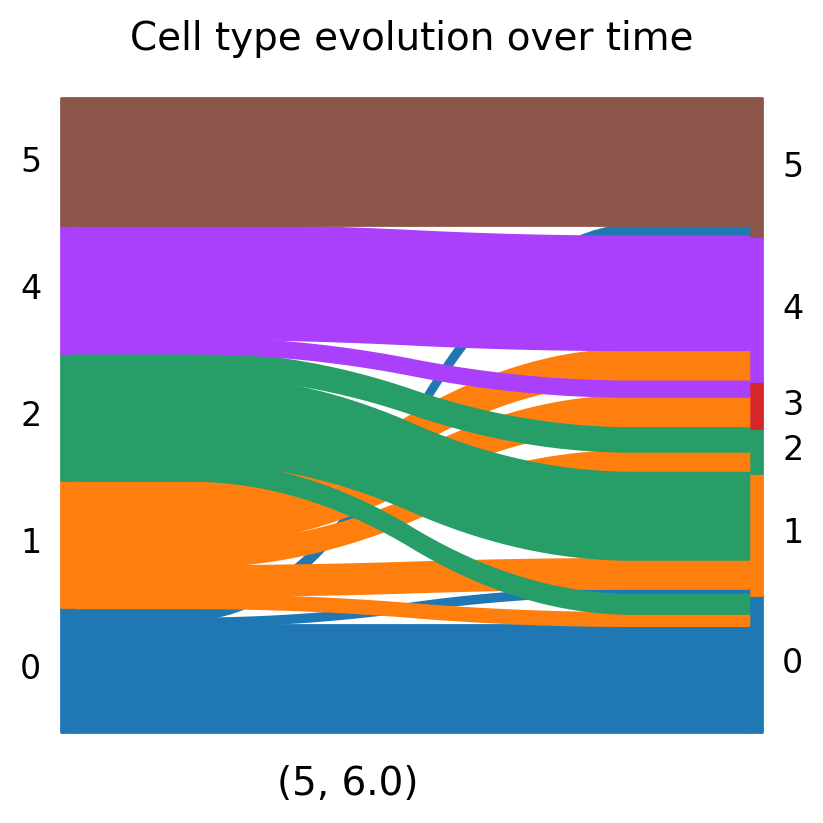

In [68]:
tp.sankey(
    source=5,
    target=6,
    source_groups={"seurat_clusters": ["0", "1", "2", "4", "5"]},
    target_groups={"seurat_clusters": ["0", "1", "2", "3", "4", "5"]},
    threshold=0.05,
    forward = True,
    key_added="sankey_5_6"
)
mtp.sankey(tp, dpi=100, figsize=(4, 4), title="Cell type evolution over time", key="sankey_5_6" ,save=out_dir + "cell_type_evolution_5-6.png")

In [60]:
adata.obs['seurat_clusters'].unique()

[1, 2, 4, 3, 5, 0]
Categories (6, int32): [0, 1, 2, 3, 4, 5]

In [69]:
# Set up the RealTimeKernel

tmk = RealTimeKernel.from_moscot(tp)

In [70]:
# to get from OT transport maps to a markov chain:
# 1. we sparsify OT transport maps by removing entries below a certain threshold; entropic regularization yields dense matrices which would make CellRank analysis very slow.
# 2. we use OT transport maps and molecular similarity to model transitions across and within time points, respectively.
# 3. we row-normalize the resulting cell-cell transition matrix (including all time points) and construct the Markov chain.

tmk.compute_transition_matrix(self_transitions="all", conn_weight=0.2, threshold="auto")

100%|██████████| 5/5 [00:00<00:00, 17105.64time pair/s]

Using automatic `threshold=0.0`


RealTimeKernel[n=576, threshold='auto', self_transitions='all']

Simulating `100` random walks of maximum length `500`


100%|██████████| 100/100 [00:10<00:00,  9.35sim/s]

    Finish (0:00:10)


Plotting random walks


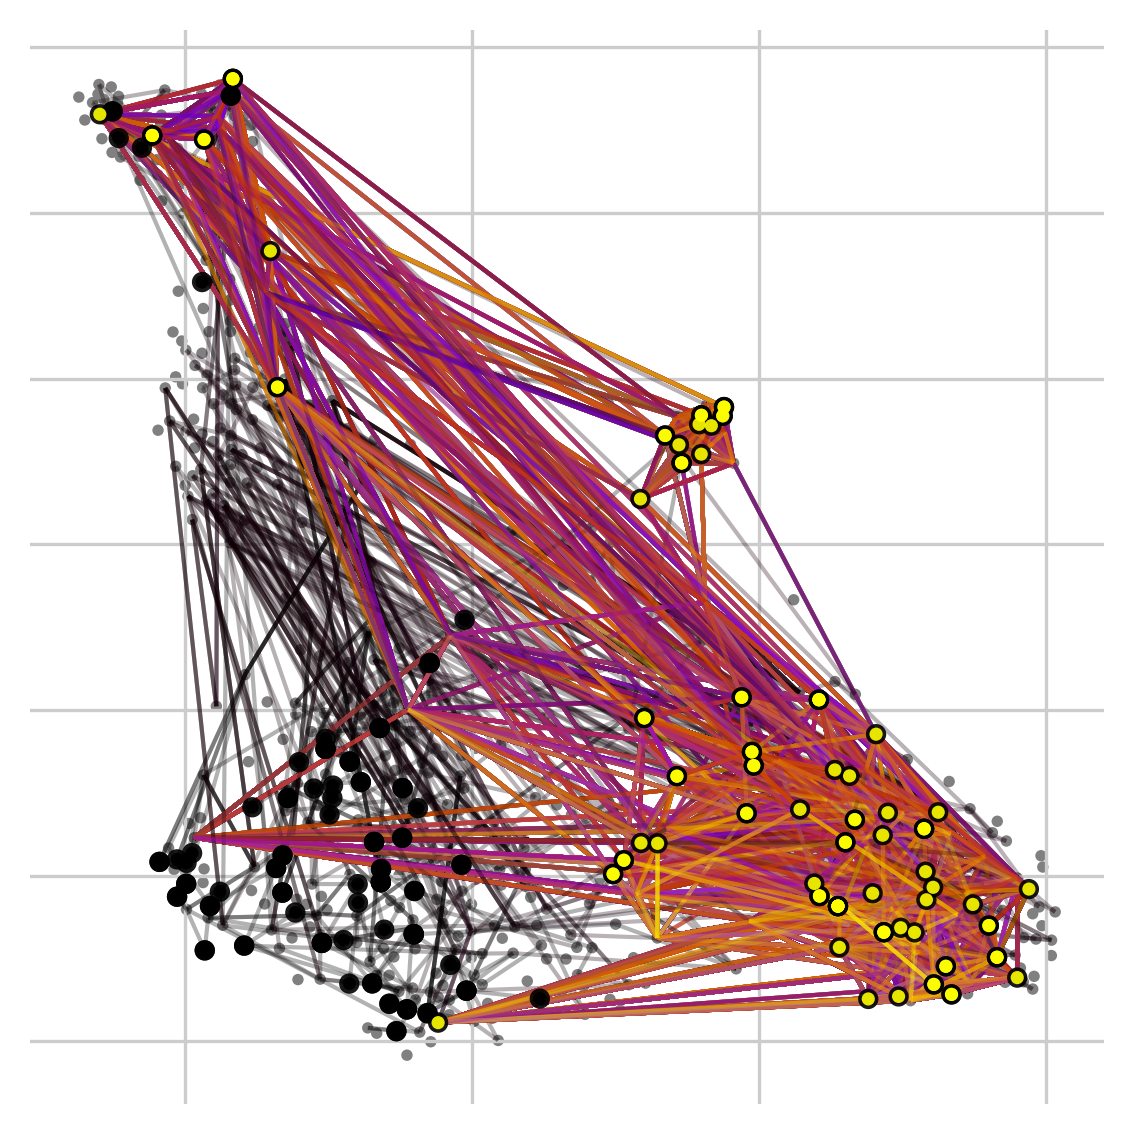

In [71]:
# Visualize the recovered dynamics by sampling random walks.
# This method simulates random walks on the Markov chain defined though the corresponding transition matrix
# Random walks are simulated by iteratively choosing the next cell based on the current cell’s transition probabilities.
with plt.rc_context():
    tmk.plot_random_walks(
        max_iter=500,
        start_ixs={"time": 1},
        basis="X_draw_graph_fa",
        seed=0,
        dpi=150,
        size=30,
    )
    plt.tight_layout()
    plt.savefig(out_dir + "random_walks.pdf", bbox_inches='tight')
    
# Black and yellow dots denote random walks starting and finishing points, respectively.

In [72]:
print(adata.obs['seurat_clusters'].unique())

['1', '2', '4', '3', '5', '0']
Categories (6, string): [0, 1, 2, 3, 4, 5]


Computing flow from `2` into `5` cluster(s) in `5` time points
Plotting flow from `2` into `3` cluster(s) in `5` time points


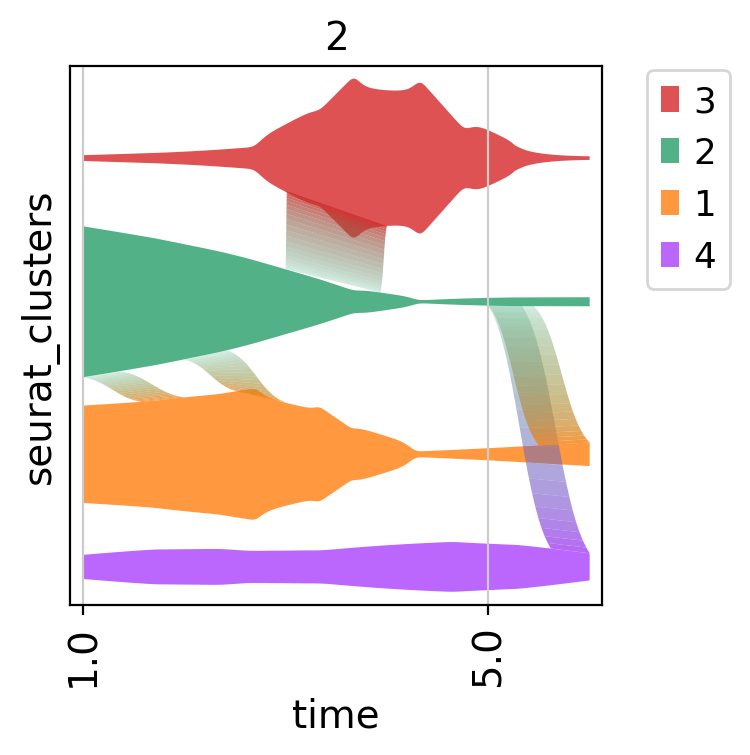

In [75]:
# plot the probability mass flow in time
# Visualize outgoing flow from a cluster of cells
with plt.rc_context():
    ax = tmk.plot_single_flow(
        cluster_key="seurat_clusters",
        time_key="time",
        cluster="2",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=["0", "1", "2", "3", "4", "5"],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_clust2.pdf", bbox_inches='tight')

Computing flow from `0` into `5` cluster(s) in `5` time points
Plotting flow from `0` into `3` cluster(s) in `5` time points
Computing flow from `1` into `5` cluster(s) in `5` time points
Plotting flow from `1` into `4` cluster(s) in `5` time points
Computing flow from `3` into `5` cluster(s) in `5` time points
Plotting flow from `3` into `5` cluster(s) in `5` time points
Computing flow from `4` into `5` cluster(s) in `5` time points
Plotting flow from `4` into `3` cluster(s) in `5` time points
Computing flow from `5` into `5` cluster(s) in `5` time points
Plotting flow from `5` into `3` cluster(s) in `5` time points


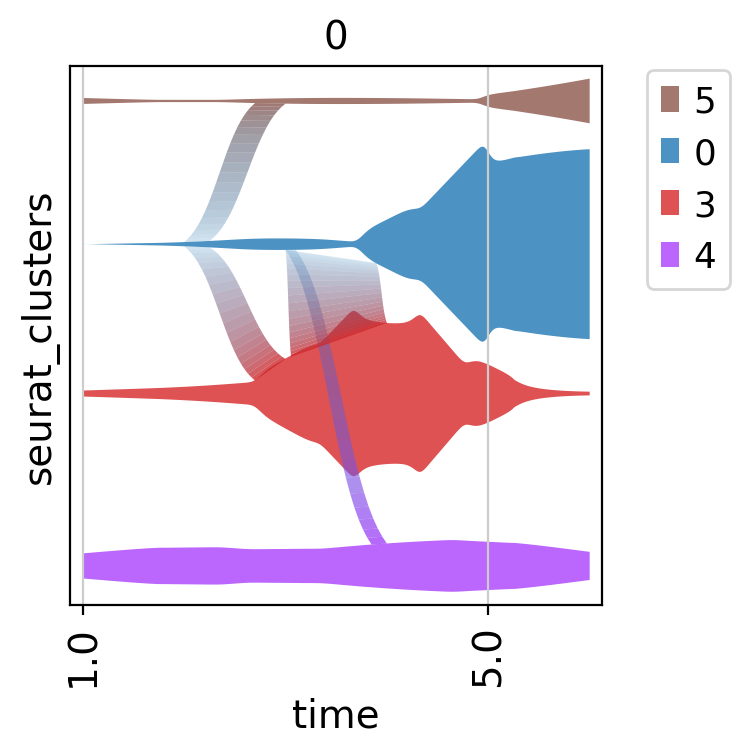

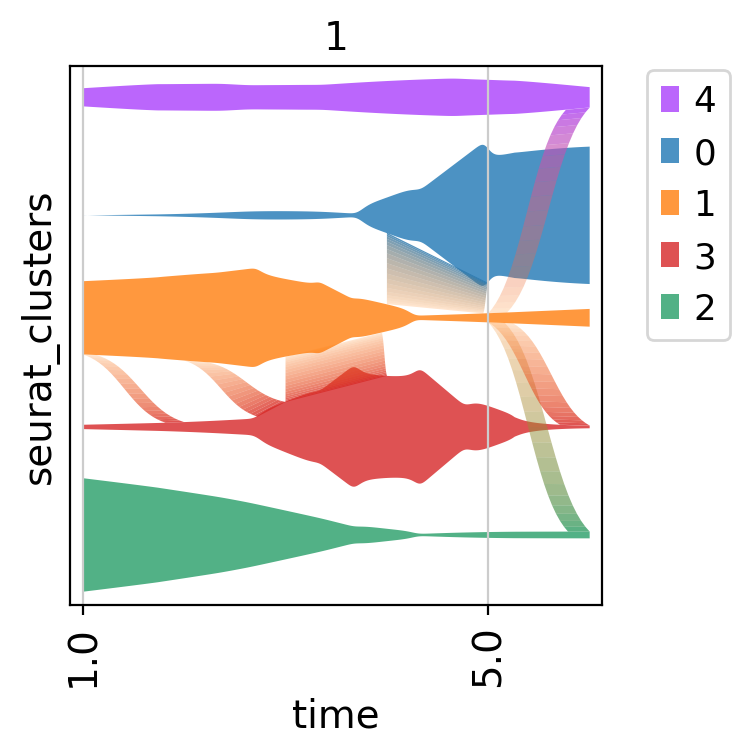

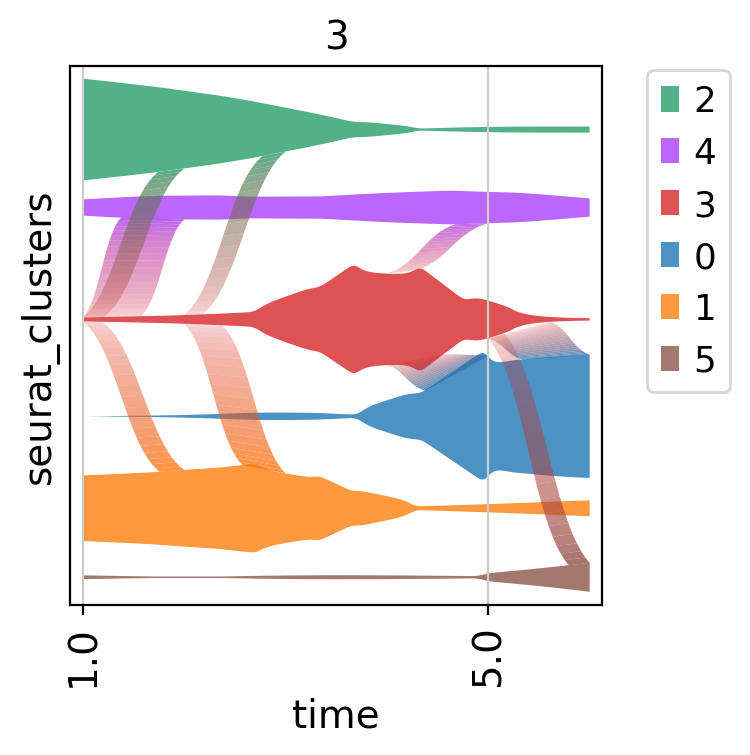

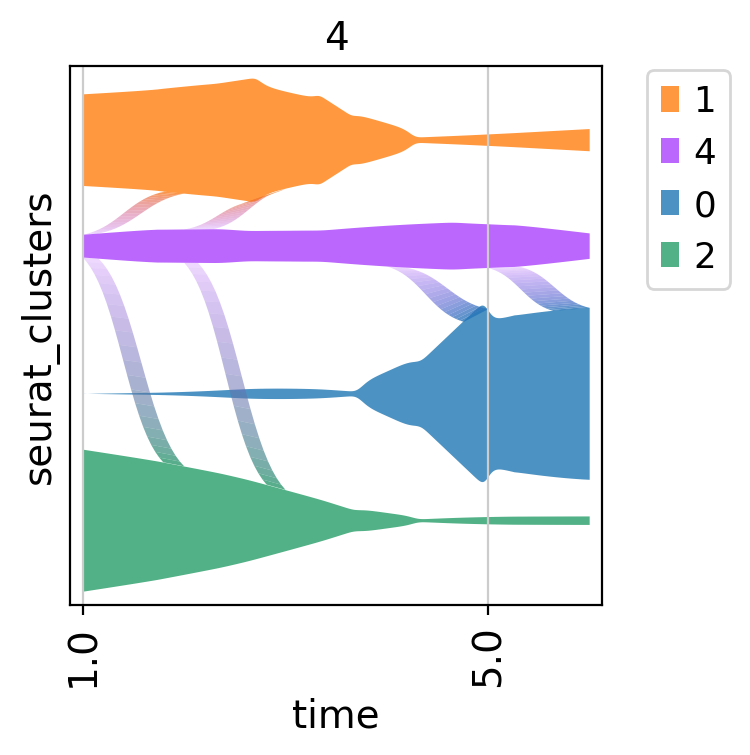

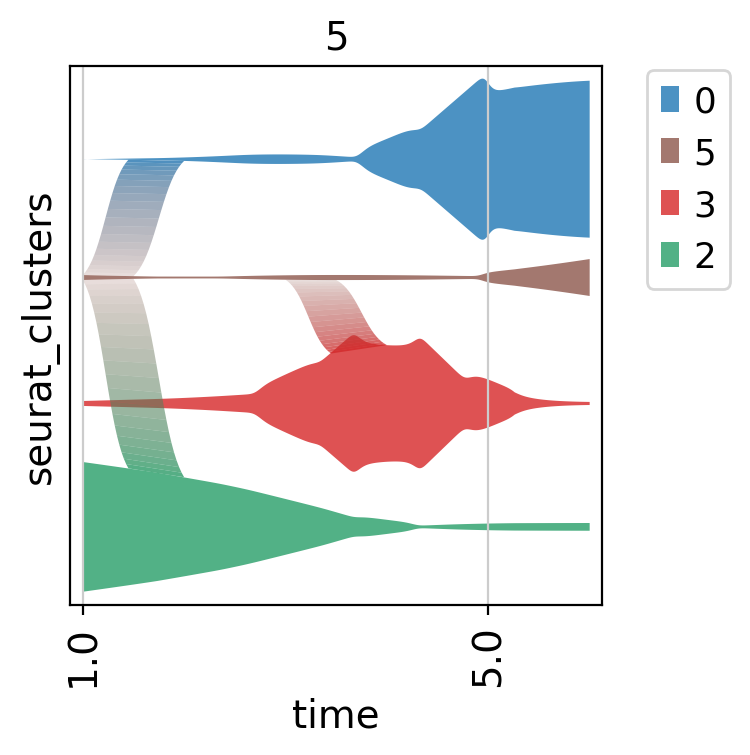

In [76]:
# plot the probability mass flow in time
# Visualize outgoing flow from a cluster of cells
with plt.rc_context():
    ax = tmk.plot_single_flow(
        cluster_key="seurat_clusters",
        time_key="time",
        cluster="0",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=["0", "1", "2", "3", "4", "5"],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_clust0.pdf", bbox_inches='tight')

with plt.rc_context():
    ax = tmk.plot_single_flow(
        cluster_key="seurat_clusters",
        time_key="time",
        cluster="1",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=["0", "1", "2", "3", "4", "5"],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_clust1.pdf", bbox_inches='tight')

with plt.rc_context():
    ax = tmk.plot_single_flow(
        cluster_key="seurat_clusters",
        time_key="time",
        cluster="3",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=["0", "1", "2", "3", "4", "5"],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_clust3.pdf", bbox_inches='tight')

with plt.rc_context():
    ax = tmk.plot_single_flow(
        cluster_key="seurat_clusters",
        time_key="time",
        cluster="4",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=["0", "1", "2", "3", "4", "5"],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_clust4.pdf", bbox_inches='tight')

with plt.rc_context():
    ax = tmk.plot_single_flow(
        cluster_key="seurat_clusters",
        time_key="time",
        cluster="5",
        min_flow=0.1,
        xticks_step_size=4,
        show=False,
        clusters=["0", "1", "2", "3", "4", "5"],
        )

    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(out_dir + "prob_mass_flow_clust5.pdf", bbox_inches='tight')